


## Feature Visulization For Cifar10 using tensorflow



### 1. Pre-processing and Model Construction

#### Cifar10 Dataset: https://www.cs.toronto.edu/~kriz/cifar.html

+ The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

+ There are 50000 training images and 10000 test images.The dataset is divided into five training batches and one test batch, each with 10000 images. 

+ The dataset archive contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch. Each of these files is a Python "pickled" object produced with cPickle.

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.python.platform import gfile
from random import randint
from IPython.display import clear_output
from IPython.display import Image
from io import BytesIO
from CIFAR10_func import *
import cifar10
import dataset
import os,sys,os.path
import seaborn as sns
sns.reset_orig()
import pandas as pd
from scipy.spatial import distance
#from sklearn.manifold import TSNE
#import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pickle

####  Load dataset: 

We have used the tutorial from [Havass-Labs](https://github.com/Hvass-Labs/TensorFlow-Tutorials) to import the dataset.


In [3]:
cifar10.data_path = "./data/CIFAR-10/"
class_name = cifar10.load_class_names()
print(class_name)

Loading data: ./data/CIFAR-10/cifar-10-batches-py/batches.meta
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
train_images_cifar10, train_class_cifar10, train_labels_cifar10 = cifar10.load_training_data()
test_images_cifar10, test_class_cifar10, test_labels_cifar10 = cifar10.load_test_data()

Loading data: ./data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: ./data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: ./data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: ./data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: ./data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: ./data/CIFAR-10/cifar-10-batches-py/test_batch


In [5]:
print("Size for the training images: {0}".format(len(train_images_cifar10)))
print("Shape for the training images: {0}".format(train_images_cifar10.shape))
print("Shape for the training labels: {0}".format(train_labels_cifar10.shape))
print("Size for the test images: {0}".format(len(test_images_cifar10)))
print("Shape for the test images: {0}".format(test_images_cifar10.shape))
print("Shape for the test labels: {0}".format(test_labels_cifar10.shape))

Size for the training images: 50000
Shape for the training images: (50000, 32, 32, 3)
Shape for the training labels: (50000, 10)
Size for the test images: 10000
Shape for the test images: (10000, 32, 32, 3)
Shape for the test labels: (10000, 10)


#### CNN Model Construction using tensorflow:

In this part, we defined and trained a convolutional network model. The structure of the model is straightforward --- two convolutional layers, each with 2*2 maxpooling and a relu gate, followed by three fully connected layers and a softmax classifier. The outputs for the last
fully connected layer were 10 scores for each input images.

In [6]:
############### 7-Layer CNN ##############
################  CIFAR10  ###############
n1 = 32
n2 = 64
n3 = 1024
n4 = 512

x = tf.placeholder(tf.float32, [None, 32, 32, 3], name='x')
y = tf.placeholder(tf.float32, [None, 10], name='y')
keep = tf.placeholder(tf.float32,name='keep')

# CNN_layer1
# use n1 5*5 filters
W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 3, n1])
b_conv1 = tf.get_variable('b_conv1', shape=[n1])
h_conv1 = tf.nn.relu(tf.add(conv2d(x, W_conv1), b_conv1))
# Pool_layer1, maxpool to 16*16
h_pool1 = maxPool2d(h_conv1)
# CNN_layer2, takes a 16x16 with 32 layers, turns to 8x8 with 64 layers
W_conv2 = tf.get_variable('W_conv2', shape=[5, 5, n1, n2])
b_conv2 = tf.get_variable('b_conv2', shape=[n2])
h_conv2 = tf.nn.relu(tf.add(conv2d(h_pool1, W_conv2), b_conv2))
# Pool_layer2
h_pool2 = maxPool2d(h_conv2)
# FC_layer1
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*n2])
W_fc1 = tf.get_variable('W_fc1', shape=[8*8*n2, n3])
b_fc1 = tf.get_variable('b_fc1', shape=[n3])
h_fc1 = tf.nn.relu(tf.add(tf.matmul(h_pool2_flat, W_fc1), b_fc1))
# FC_layer2
W_fc2 = tf.get_variable('W_fc2', shape=[n3, n4])
b_fc2 = tf.get_variable('b_fc2', shape=[n4])
h_fc2 = tf.nn.relu(tf.add(tf.matmul(h_fc1, W_fc2), b_fc2))
# drop_out layer
h_fc2_drop = tf.nn.dropout(h_fc2, keep)
# FC_layer3
W_fc3 = tf.get_variable('W_fc3', shape=[n4, 10])
b_fc3 = tf.get_variable('b_fc3', shape=[10])
logits = tf.add(tf.matmul(h_fc2, W_fc3), b_fc3)
loss = compute_cross_entropy(logits=logits, y=y)
accuracy = compute_accuracy(logits, y)
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



####  Train the model

In this part, we trained our predefined CNN model.In this part The validation accuracy is about 63% in the end, which is acceptabl as our goal here is to do visualization on features to find some patterns, we used our final trained model to do so.You can retrain the model from the following code, or you can just load our trained model in the output file.

In [7]:
# loss = compute_cross_entropy(logits=logits, y=y)
# accuracy = compute_accuracy(logits, y)
# train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

# # Validation set
# batch_all = random_batch(data_images=test_images_cifar10, data_labels=test_labels_cifar10, batch_size=100)
# valid_img = batch_all[0]
# valid_lab = batch_all[1]

# batch_size =100
# input_images = train_images_cifar10
# input_labels = train_labels_cifar10
# num_step = 20001

# with tf.Session() as sess:
#         sess.run(tf.global_variables_initializer())
        
#         for i in range(num_step):
#             # Training set
#             batch_all = random_batch(data_images=input_images, data_labels=input_labels, batch_size=batch_size)
#             train_img = batch_all[0]
#             train_lab = batch_all[1]
            
#             sess.run(train_step, feed_dict={x: train_img, y: train_lab, keep: 0.5})
            
#             if i%1000 == 0: 
#                 valid_acu = sess.run(accuracy, {x: valid_img, y: valid_lab, keep:1.0})
#                 print("\rAfter step {0:3d}, validation accuracy {1:0.4f}".format(i, valid_acu))
#             if i%10000 == 0:
#                 saver = tf.train.Saver()
#                 saver.save(sess, ".output/model_on_cifar10/", global_step=i)

#### Load model

To save the time spent on training, you can load our model directly from following codes

In [8]:
tf.reset_default_graph()
with tf.Session() as sess:
    # Load the saved model
    new_saver = tf.train.import_meta_graph("./output/model_on_cifar10/-20000.meta")
    new_saver.restore(sess, tf.train.latest_checkpoint('./output/model_on_cifar10/'))

INFO:tensorflow:Restoring parameters from ./output/model_on_cifar10/-20000


###  2. Visualization of CNN model on cifar10 dataset 

In [9]:
# split dataset image randomly

batch_size = 100
input_images = train_images_cifar10
input_labels = train_labels_cifar10
batch_all = random_batch(data_images=input_images, 
                             data_labels=input_labels, 
                             batch_size=100)
input_img = batch_all[0]
input_lab = batch_all[1]

#### 2.1 Visualize the activation map of the first convolutional layer

##### 2.1.1 Activation map of convolutional layer 1

INFO:tensorflow:Restoring parameters from ./output/model_on_cifar10/-20000


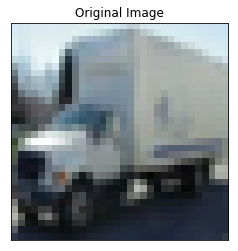

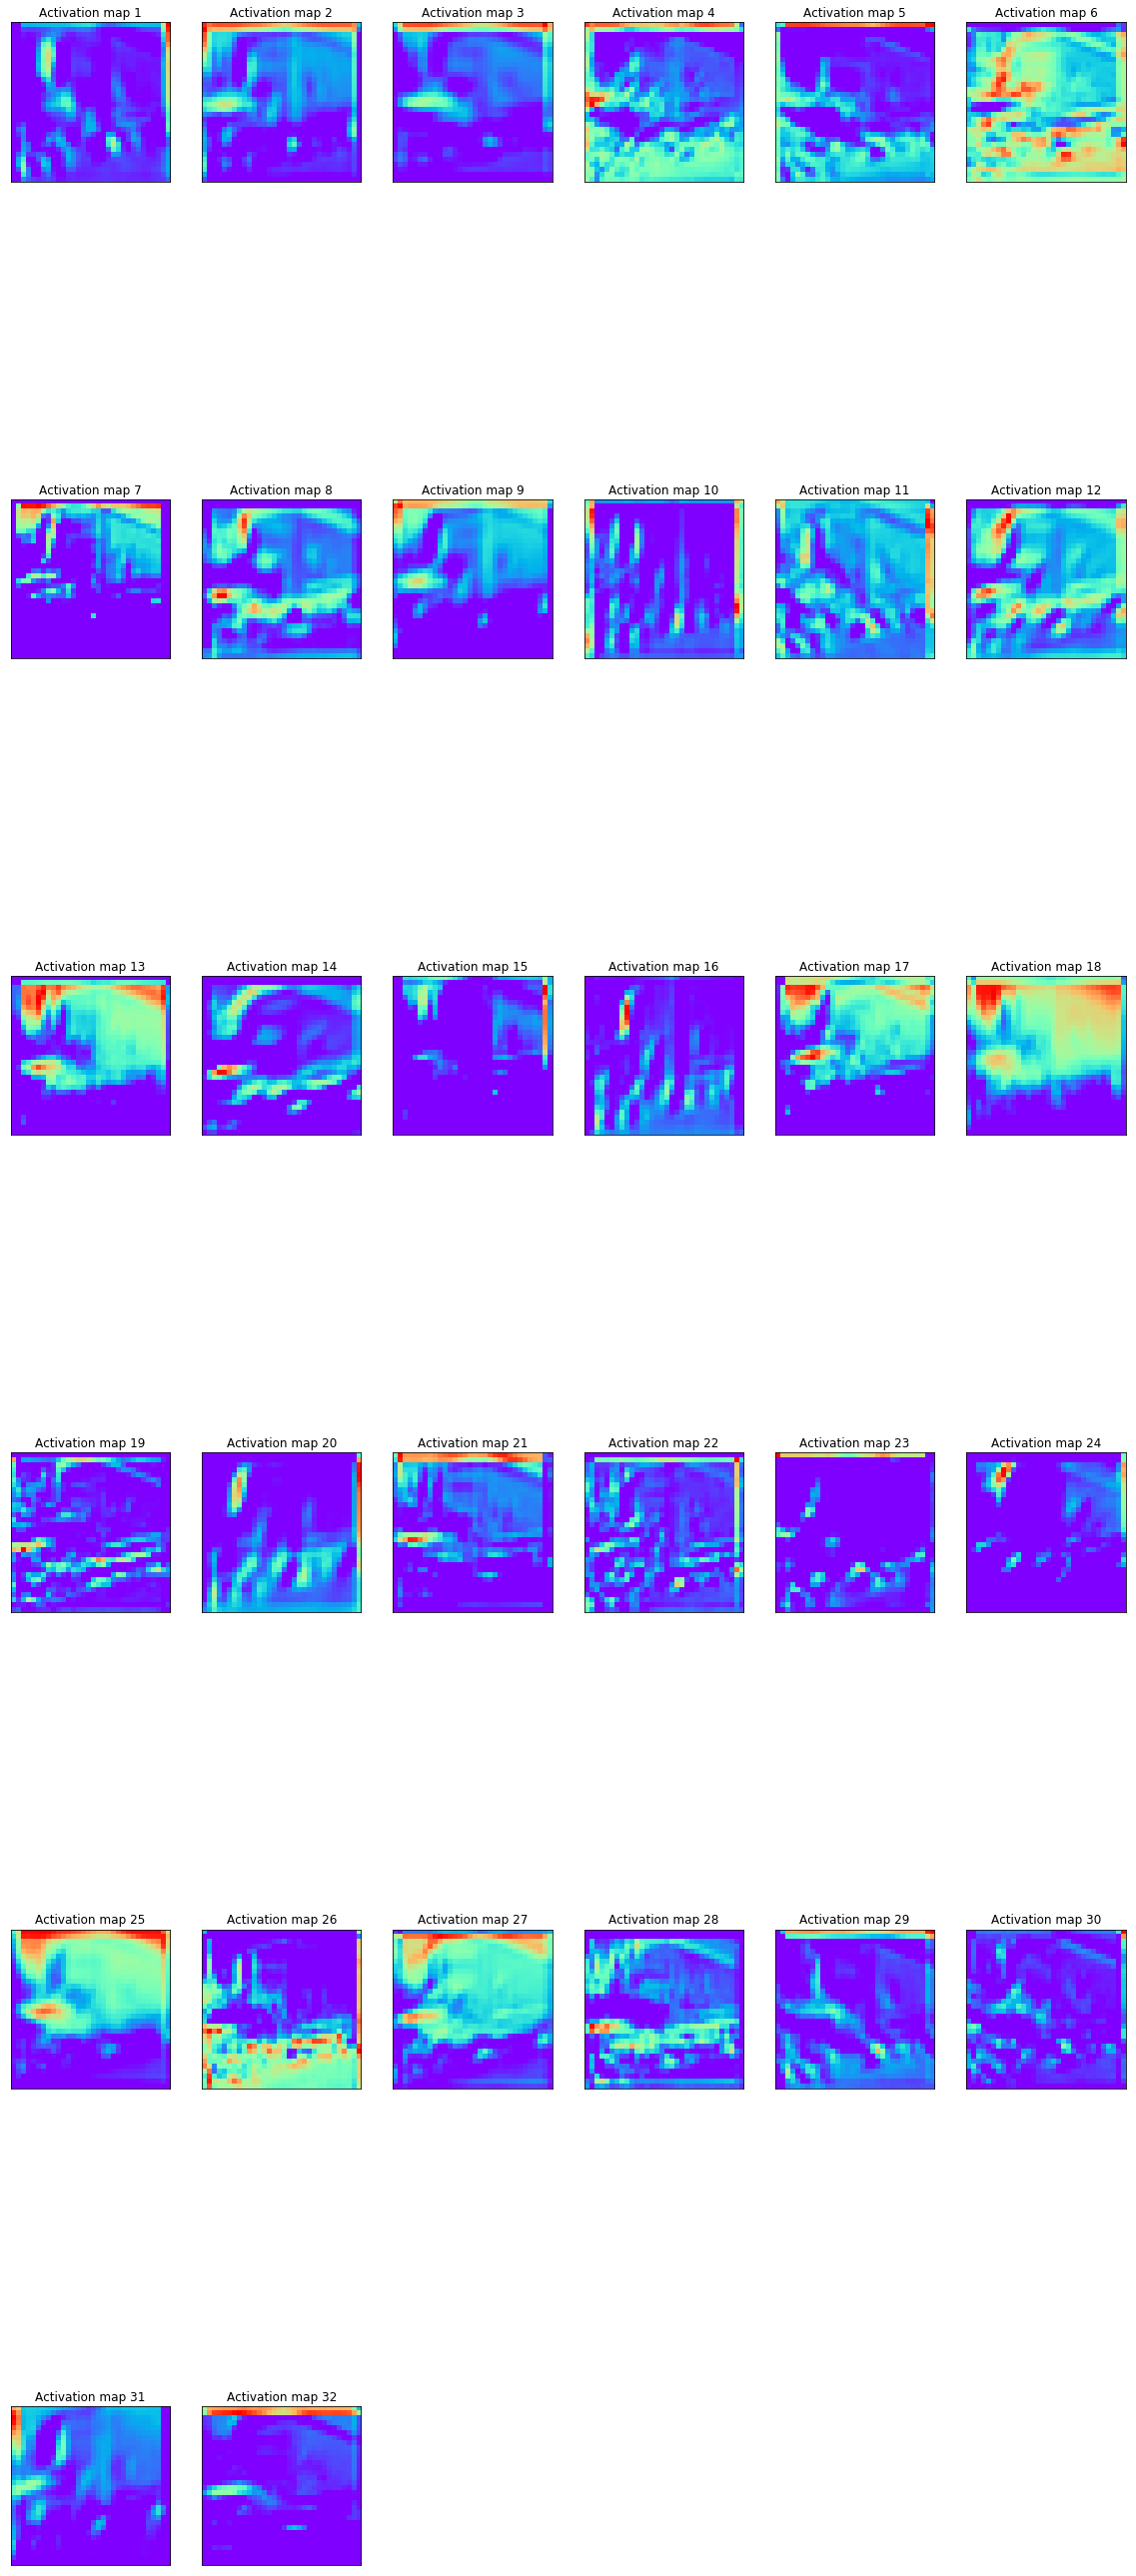

In [11]:
getActivations(layer_name="Relu:0", input_images=input_img, image_idx=1) # get the activation map of 1st convolutional layer

##### 2.1.2 Activation map of convolutional layer 2

INFO:tensorflow:Restoring parameters from ./output/model_on_cifar10/-20000


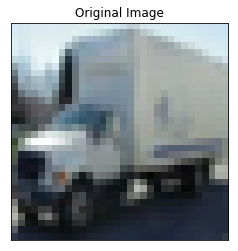

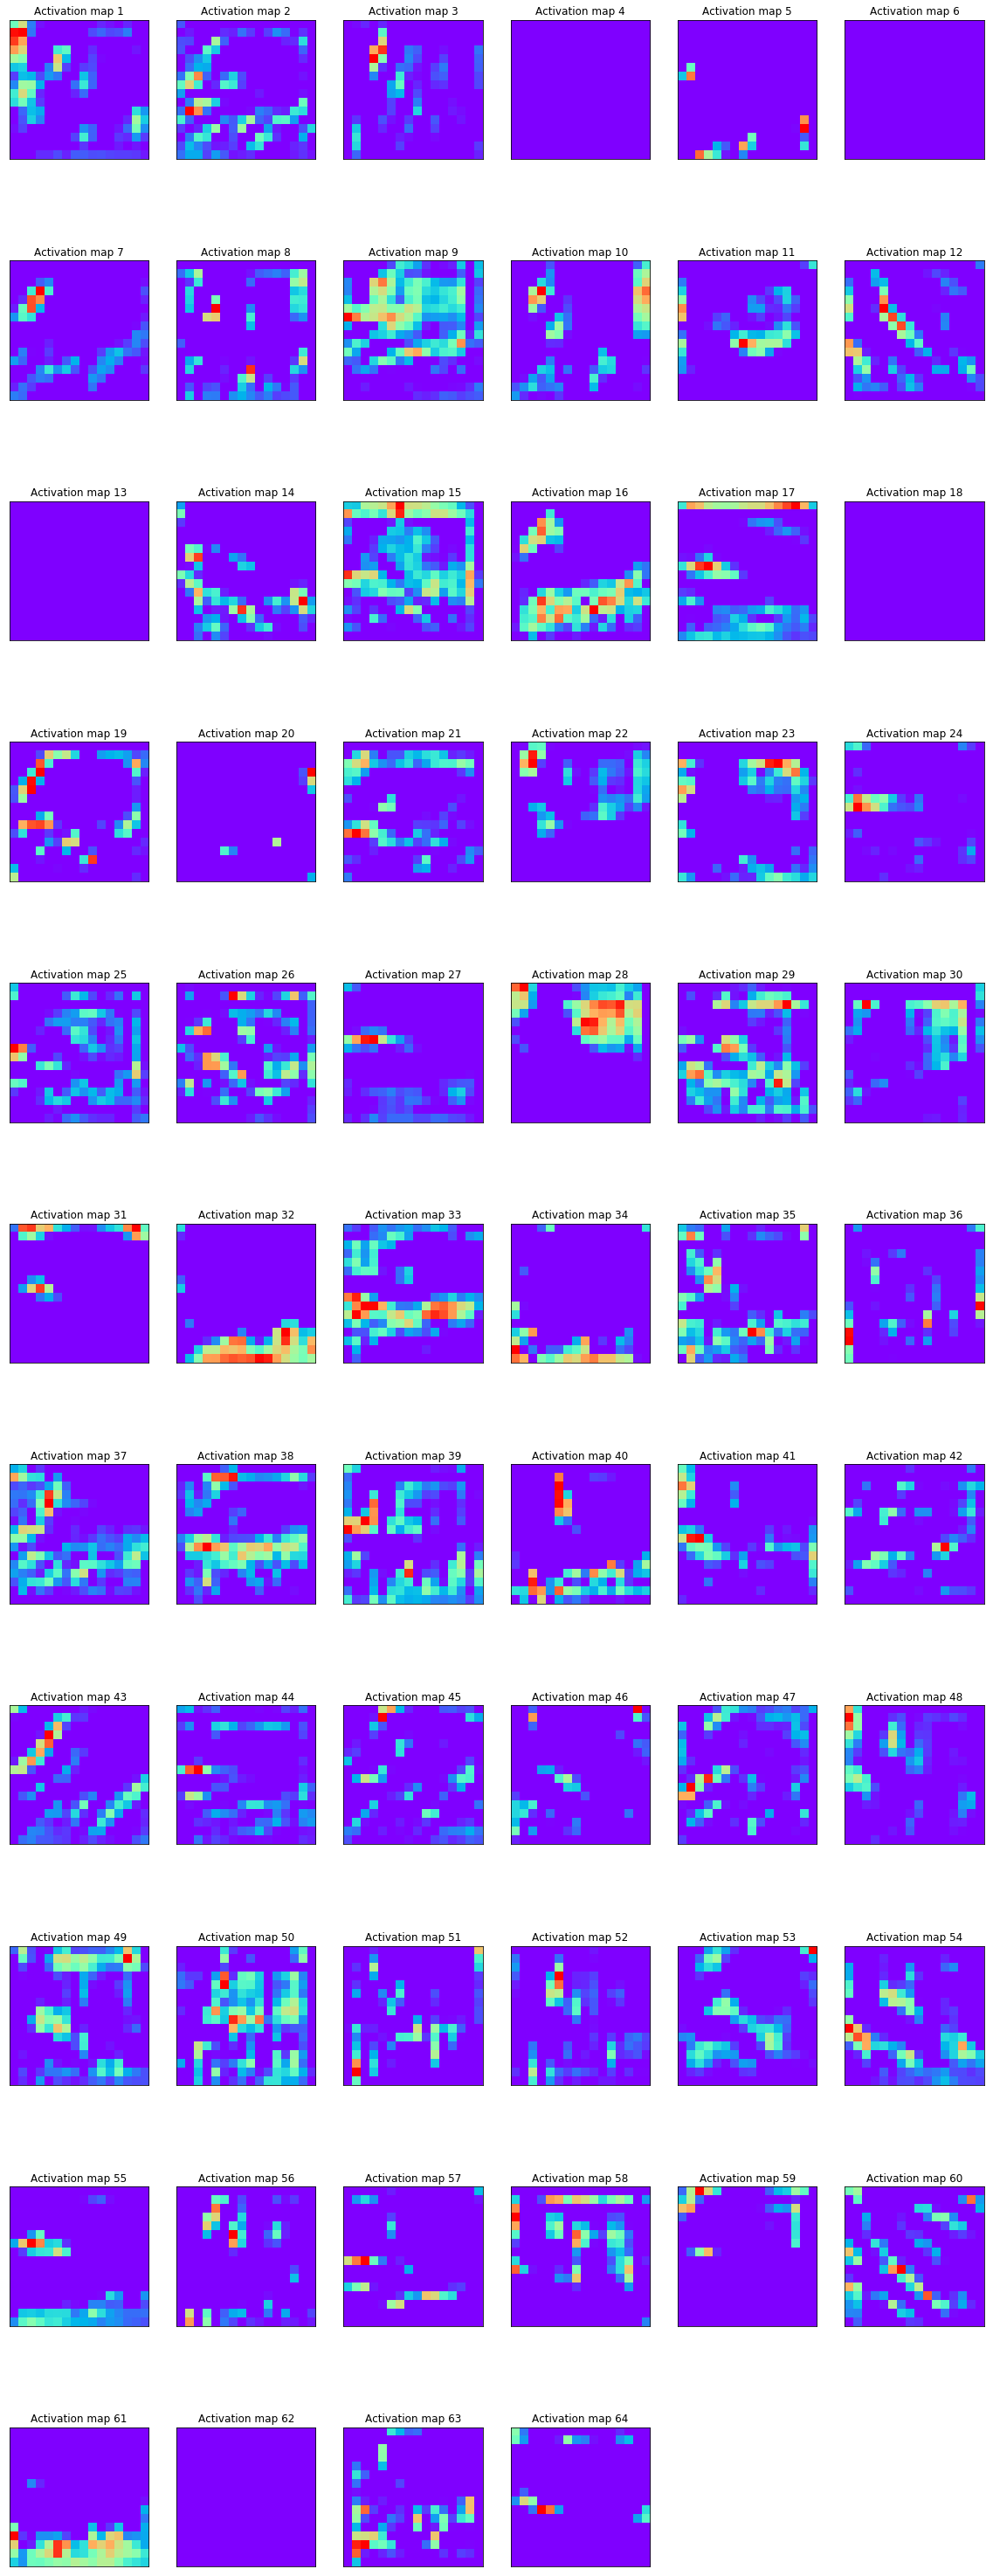

In [12]:
getActivations(layer_name="Relu_1:0", input_images=input_img, image_idx=1)

Above plots showed the activation maps of convolutional layer 1 and convolutional layer 2. It showed that the 1st convolutional layer extract the basic features of the orginal picture so basically we can identify the orginal object though it is not that clear. However, in convolutional layer 2, the features extracted are more abstract and even some maps extract no features.We cannot know what the original objec is from activation maps of convolutional 2.

#### 2.2 Visualize the activation maps activated the most in 1st and 2nd convolutional layer

##### 2.2.1 The activation map activated the most in 1st convolutional layer

INFO:tensorflow:Restoring parameters from ./output/model_on_cifar10/-20000

For the fist convolutional layer:



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

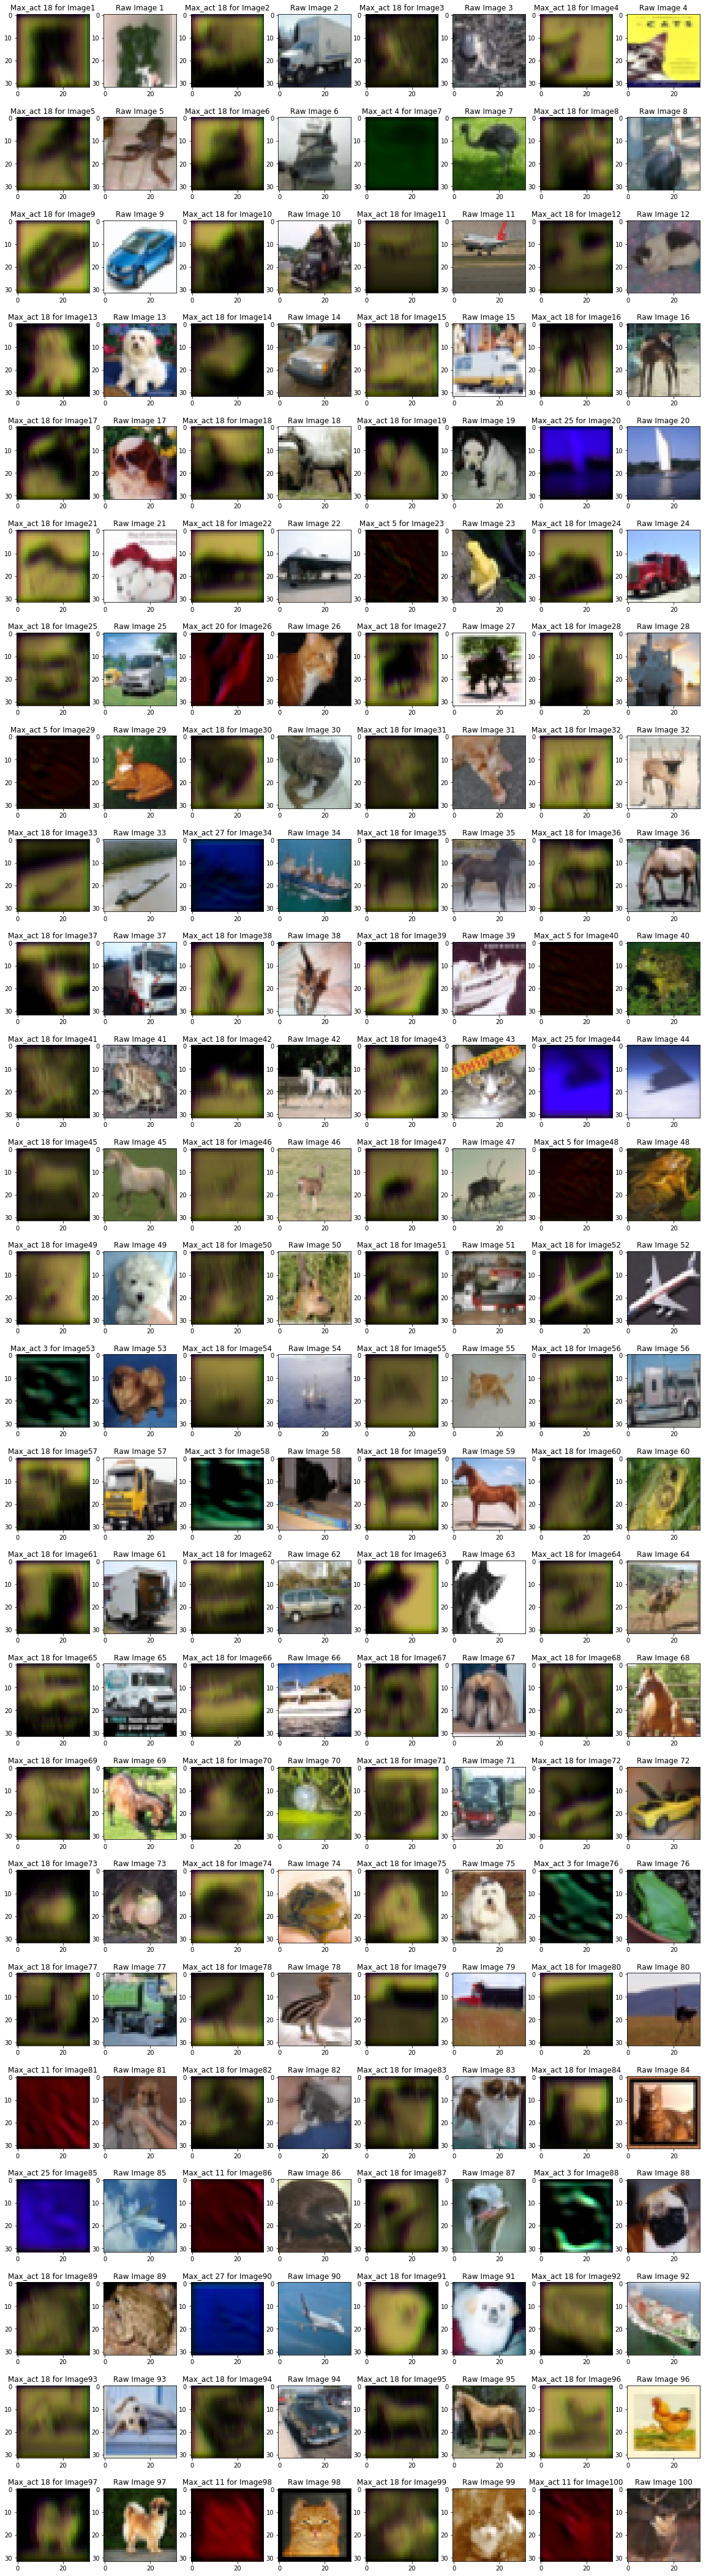

In [13]:
max_activations_CONV1_cifar10(input_images=input_img, input_labels=input_lab, batch_size=100, n1=32)

From the plots of the activation map activated maximally shown above we can see that, a rough figure for each image.Though it is not very clear, but it still extracts some basic features that we can basically identify what the object is. The first convolutional layer have tried to learn some outstanding patterns from input images, but it still seemed to be unsuccessful. And No.18 activation map has been shown for most the images, which at some points indicated that this filter activated maximally for most of the pictures given.

##### 2.2.2 Visualize maximal activation maps of the 2nd convolutional layer

INFO:tensorflow:Restoring parameters from ./output/model_on_cifar10/-20000

For the second convolutional layer:



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

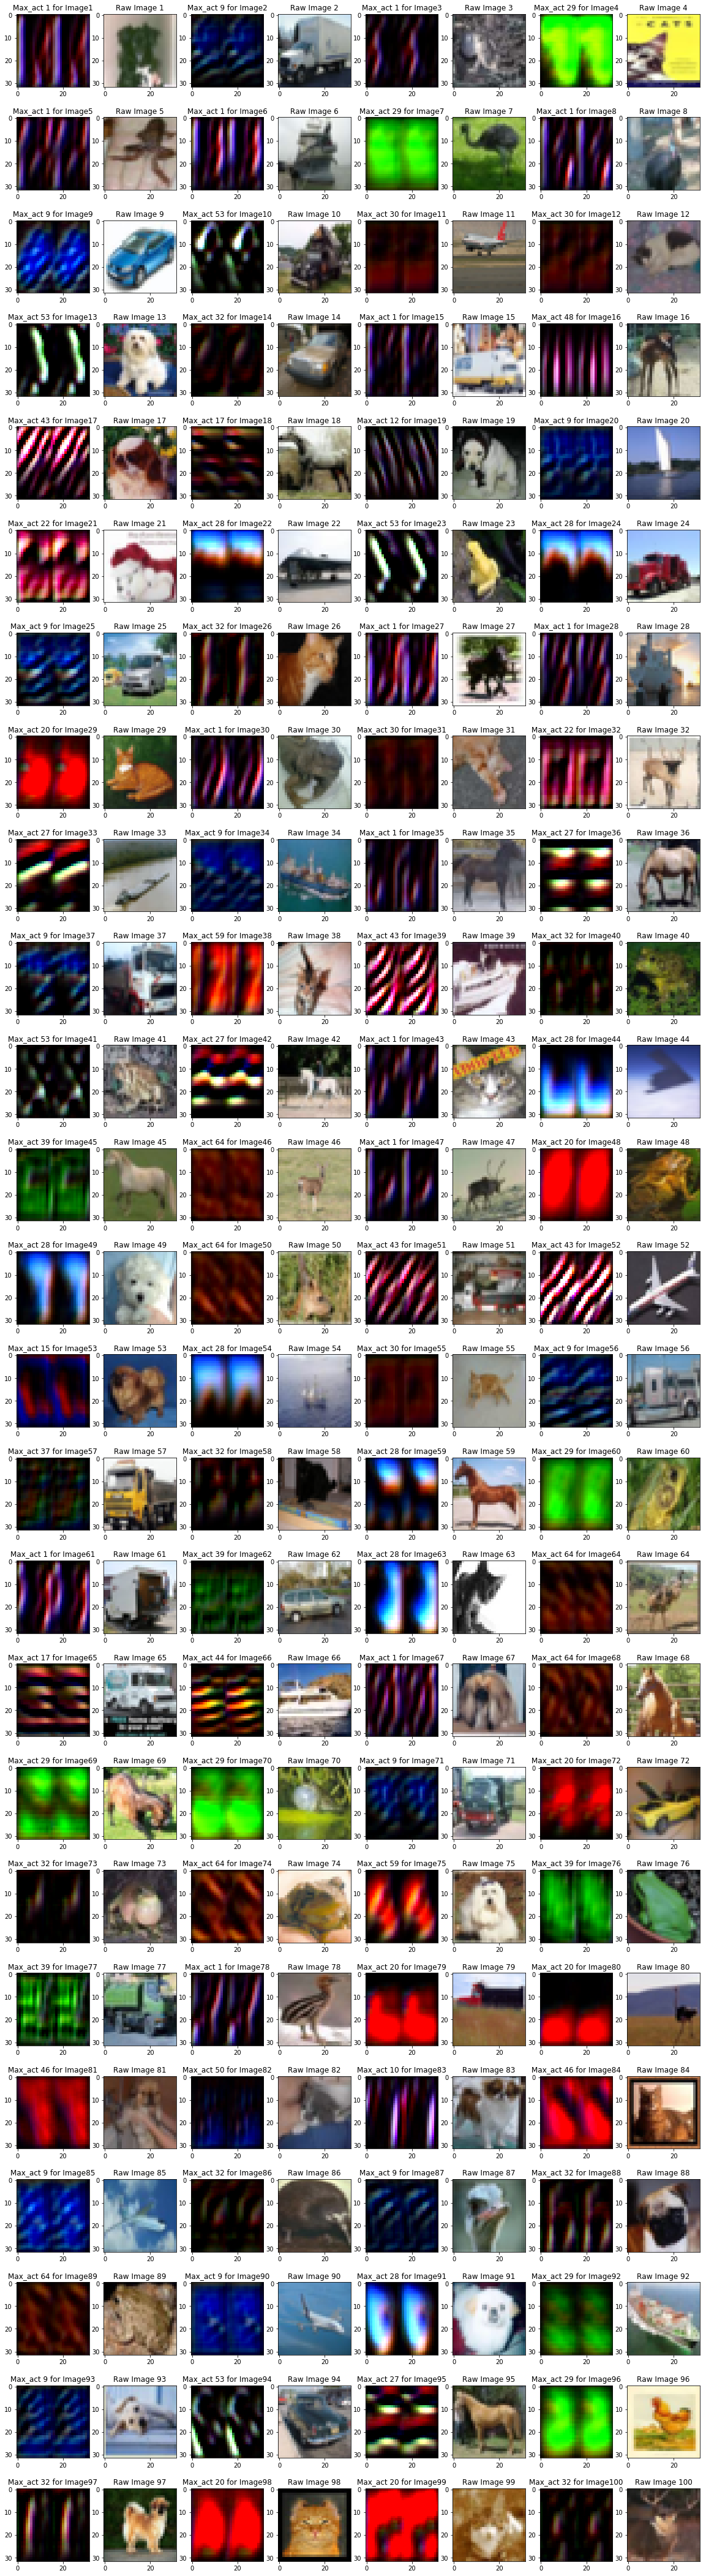

In [14]:
max_activations_CONV2_cifar10(input_images=input_img, input_labels=input_lab, batch_size=100, n1=32, n2=64)

From the plots shown above we can see that, the second convolutional layer seems to learn the
outlines of objects from the backgrounds by the presence of distinct color patterns. But, obviously
it's not very successful.And compared with the first layer, we basically cannot identify the object from the activation map that activated maximumly.

#### 2.3 Visualize saliency maps

In this part, we are trying to do saliency visualizations for given images. 

INFO:tensorflow:Restoring parameters from ./output/model_on_cifar10/-20000

The shape after taking gradients with respect to input images: (100, 32, 32, 3, 10)

Taking gradients with respect to input images:



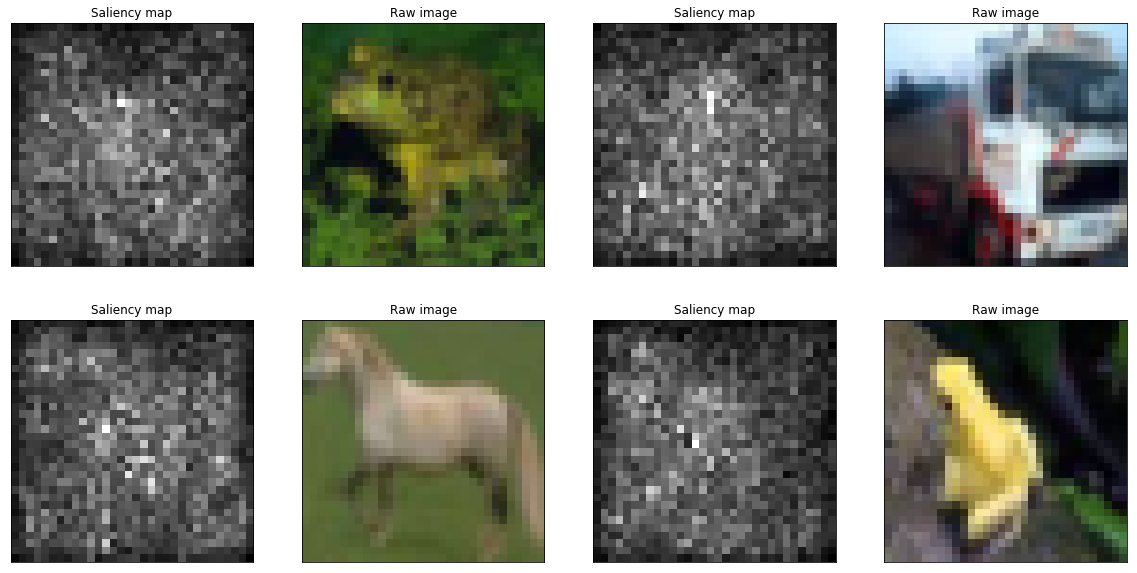

In [15]:
Grad_cifar10(layer_name="Add_4:0", input_images=input_img, input_labels=input_lab, batch_size=100)

From the plots shown above we can see that, the outlines of the main objects for input images are
not very clear, at some points due to the pool visualization for the raw images, but still can figure
something out with raw images. These saliency maps at some points tell us which pixels matter for
the classifications.

#### 2.4 Visualize back-propagation maps

In this part, we are trying to do back-propagation visualization for given images from a specific
layer in CNN.

##### 2.4.1 Taking gradients for the 2nd maxpooling layer

INFO:tensorflow:Restoring parameters from ./output/model_on_cifar10/-20000

The shape after taking gradients with respect to input images: (100, 32, 32, 3, 8)

Taking gradients with respect to input images:



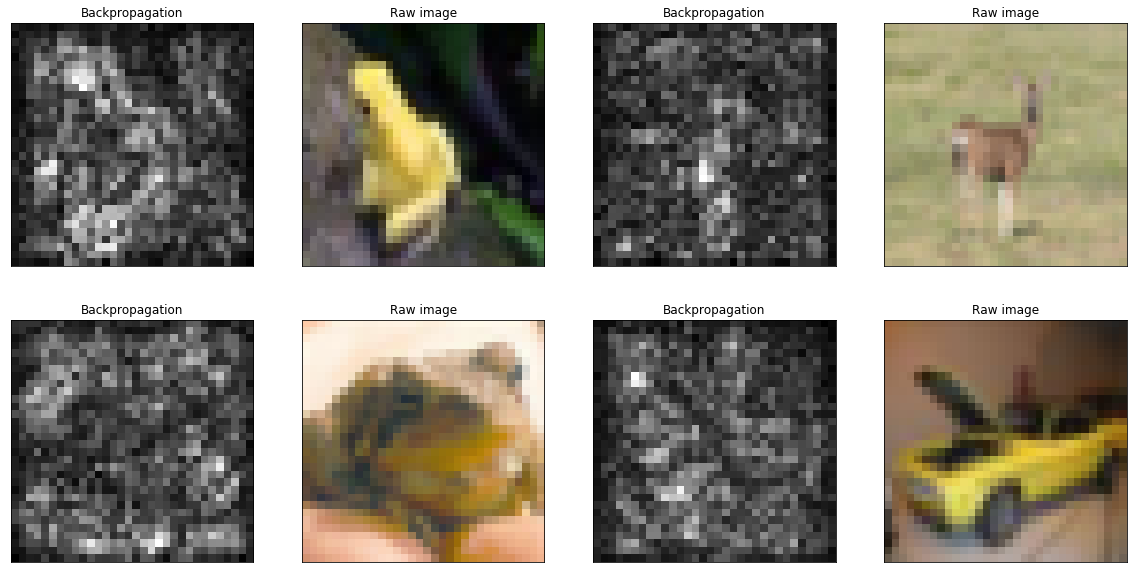

In [16]:
Grad_cifar10(layer_name="MaxPool_1:0", input_images=input_img, input_labels=input_lab, batch_size=100)

From the plots shown above we can see that, the outlines of the main objects for input images are
not very clear, the same for the raw imags. These back-propogation maps at some points show us
which pixels matter for the second maxpooling layer in our CNN.

##### 2.4.2 Taking gradients for the 2nd convolutional layer


INFO:tensorflow:Restoring parameters from ./output/model_on_cifar10/-20000

The shape after taking gradients with respect to input images: (100, 32, 32, 3, 16)

Taking gradients with respect to input images:



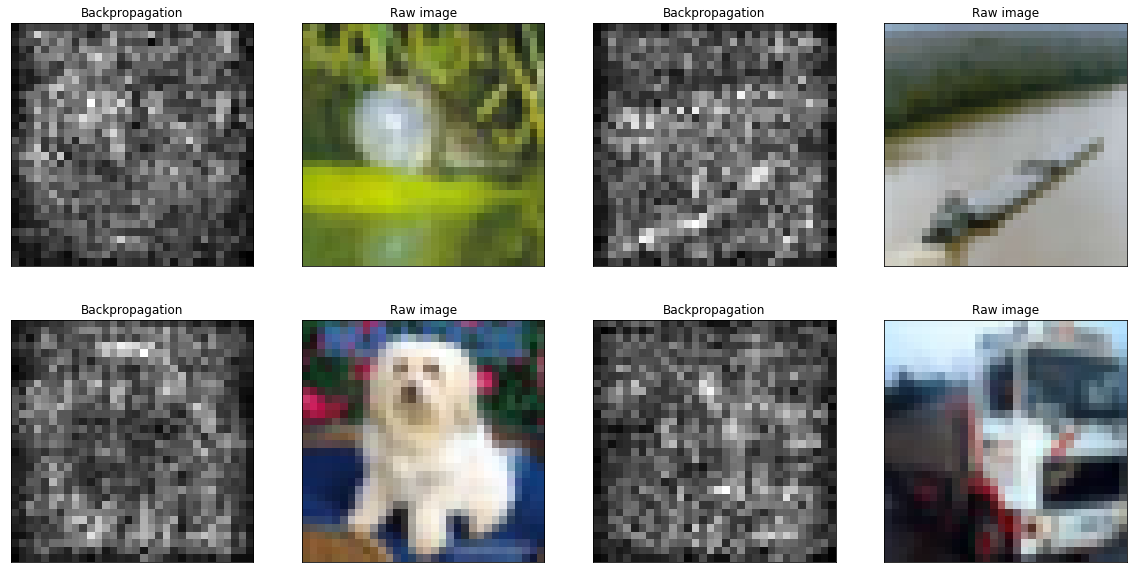

In [17]:
Grad_cifar10(layer_name="Relu_1:0", input_images=input_img, input_labels=input_lab, batch_size=100)

From the plots shown above we can see that, the outlines of the main objects for input images are not very clear, due to the poor visualization for input images. These back-propogation maps at some
points show us which pixels matter for the second convolutional layer in our CNN.

### 3. Activation Maximization on Cifar10 using keras

In this part, we focus on activation maximization. The general idea of activation maximization is to generate an input image which maximizes the filter output activations. By minimizing losses during gradient descent iterations, we can understand what sort of input patterns
activate a particular filter.( [Visualizing Higher-Layer Features of a Deep Network](https://pdfs.semanticscholar.org/65d9/94fb778a8d9e0f632659fb33a082949a50d3.pdf)). In this part, we refer the code from [here](https://github.com/budingtanke/Feature-Visualization-for-CNN).

#### 3.1 Basic  Activation Maximization

To achieve this goal, first we need to define a loss function to calcualte Activation Maximization Loss.
We ramdomly intialize an image as the start point of our gradient descent interation process. In each
interation, we calculate the gradient of loss with respect to input image, then use it to update the input
in order to reduce Activation Maximization Loss. Here we use keras package to achieve this goal.

In [18]:
# Network structure here is the same to what we use in tensorflow
from MaxActivation import *
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation, Input
from keras.models import Sequential
from keras import backend as K
from keras.models import load_model
IMG_WEIGHT, IMG_HEIGHT = 32, 32
model_path = './keras_saved_models/keras_cifar10_trained_model.h5'
keras_model =  load_model(model_path)

Using TensorFlow backend.


In [19]:
keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 32)        2432      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        51264     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              4195328   
_________________________________________________________________
fc2 (Dense)                  (None, 512)               524800    
__________

In [20]:
import matplotlib.pyplot as plt
if K.image_data_format() == 'channels_first':
    input_shape = (3, IMG_WEIGHT, IMG_HEIGHT)
elif K.image_data_format() == 'channels_last':
    input_shape = (IMG_WEIGHT, IMG_HEIGHT, 3)
#init_img = np.random.random(input_shape) * 20 + 128.0
init_img = np.zeros(input_shape)
img = deprocess_image(init_img)

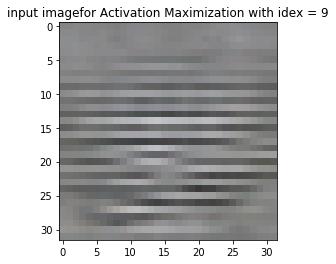

In [21]:
class_idx = 9
img = init_img[np.newaxis, :]
new_img = visualize_activation(keras_model, class_idx, img, n_iteration=100, verbose=False)
new_img = deprocess_image(new_img)
plt.imshow(new_img[0,:])
plt.title("input imagefor Activation Maximization with idex = 9")
plt.show()

If we input above image, the CNN model will define this picture as class 9 with the highest probability as this input image can activate the particular unit of CNN model most.

#### 3.2 High Confidence Predictions for Unrecognizable Images

##### Increase Rate of Converge and Deal with High-frequency Patterns Using Regularization

There exist two problems in our preliminary trial above. Firstly, the image is updated at a too slow
rate that we can't achieve a relevant ideal loss within 500 interation, even if we set the learning rate
as 10. Secondly, images we generated above seem to be unrecognizable by humans. This is an
issue regarded as the enemy of feature visualization according to Chris Olah from Google team
(https://distill.pub/2017/feature-visualization/). It often ends up with a kind of neural network optical
illusion — an image full of noise and nonsensical high-frequency patterns that the network responds
strongly to.
To solve these problems, we explored several regularization methods and combined them to
enhance the effect. Generally speaking, there are two major ideas. One is to apply some modification
to the image after each optimization step so that the algorithm tends toward nicer images. The other
is to modify the loss so that the learning process favors more natural images over unnatural ones.

#### 3.2.1 Decay


This regularization method refers to the paper Understanding Neural Networks Through Deep
Visualization (https://arxiv.org/abs/1506.06579). A simple regularization is to make the image closer
to the mean at each step. It avoids bright pixels with very high values by penalizing large values.
Decay tends to prevent a small number of extreme pixel values from dominating the example image.
Such extreme single-pixel values neither occur naturally with great frequency nor are useful for
visualization.

#### 3.2.2 Blur

This regularization method refers to the paper Understanding Neural Networks Through Deep
Visualization (https://arxiv.org/abs/1506.06579). Producing images via gradient ascent can arrive at
high activations, but they are neither realistic nor interpretable. A useful regularization is thus to
penalize high frequency information to make the image smoother.

#### 3.2.3 Clipping pixels with small norm

This regularization method refers to Understanding Neural Networks Through Deep Visualization
(https://arxiv.org/abs/1506.06579). After applied two regulations above, even if some pixels show the
primary object or type of input, the gradient with respect to all other pixels will still generally be nonzero,
so these pixels will also shift to show some pattern as well.Our goal in this step is the clip pixels
with small norms so that we can remove their effect on maximizing the activation.

##### Without regularization

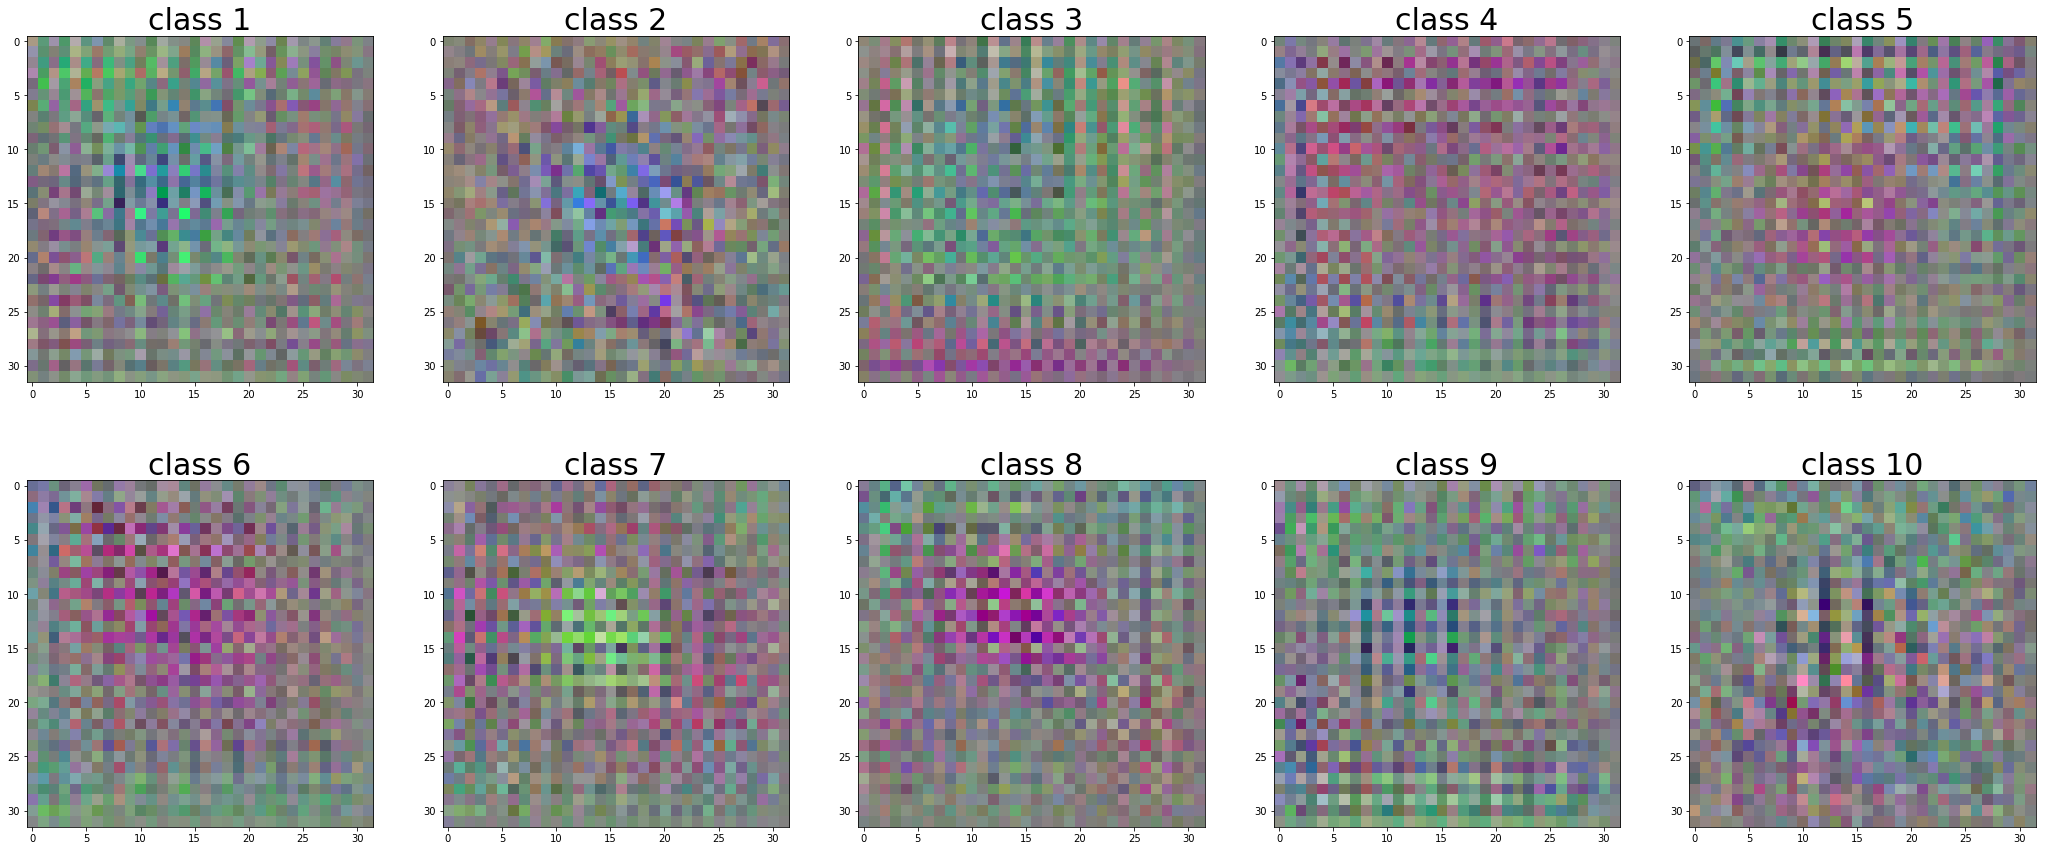

In [25]:
g_images = []
fig_act = plt.figure(figsize=(36,15))
for class_idx in range(10):
    img = init_img[np.newaxis, :]
    new_img = visualize_activation_basic(keras_model, class_idx, img, n_iteration=100, verbose=False)
    new_img = deprocess_image(new_img)
    g_images.append(new_img) 
    plt.subplot(2,5,class_idx+1)
    plt.imshow(new_img[0,:])
    plt.title("class %d" %(int(class_idx)+1),fontsize=30)
plt.show() 

In [23]:
for class_idx in range(10):
    scores = keras_model.predict(g_images[class_idx])
    print("score distribution when we set class as %d"% class_idx )
    print(scores) #show the score each pictrue classfied as diffrent index

score distribution when we set class as 0
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
score distribution when we set class as 1
[[3.4174303e-04 9.9965823e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
score distribution when we set class as 2
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
score distribution when we set class as 3
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
score distribution when we set class as 4
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
score distribution when we set class as 5
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
score distribution when we set class as 6
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
score distribution when we set class as 7
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
score distribution when we set class as 8
[[0.00115583 0.         0.         0.         0.         0.
  0.         0.         0.         0.99884415]]
score distribution when we set class as 9
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


#### With regularization

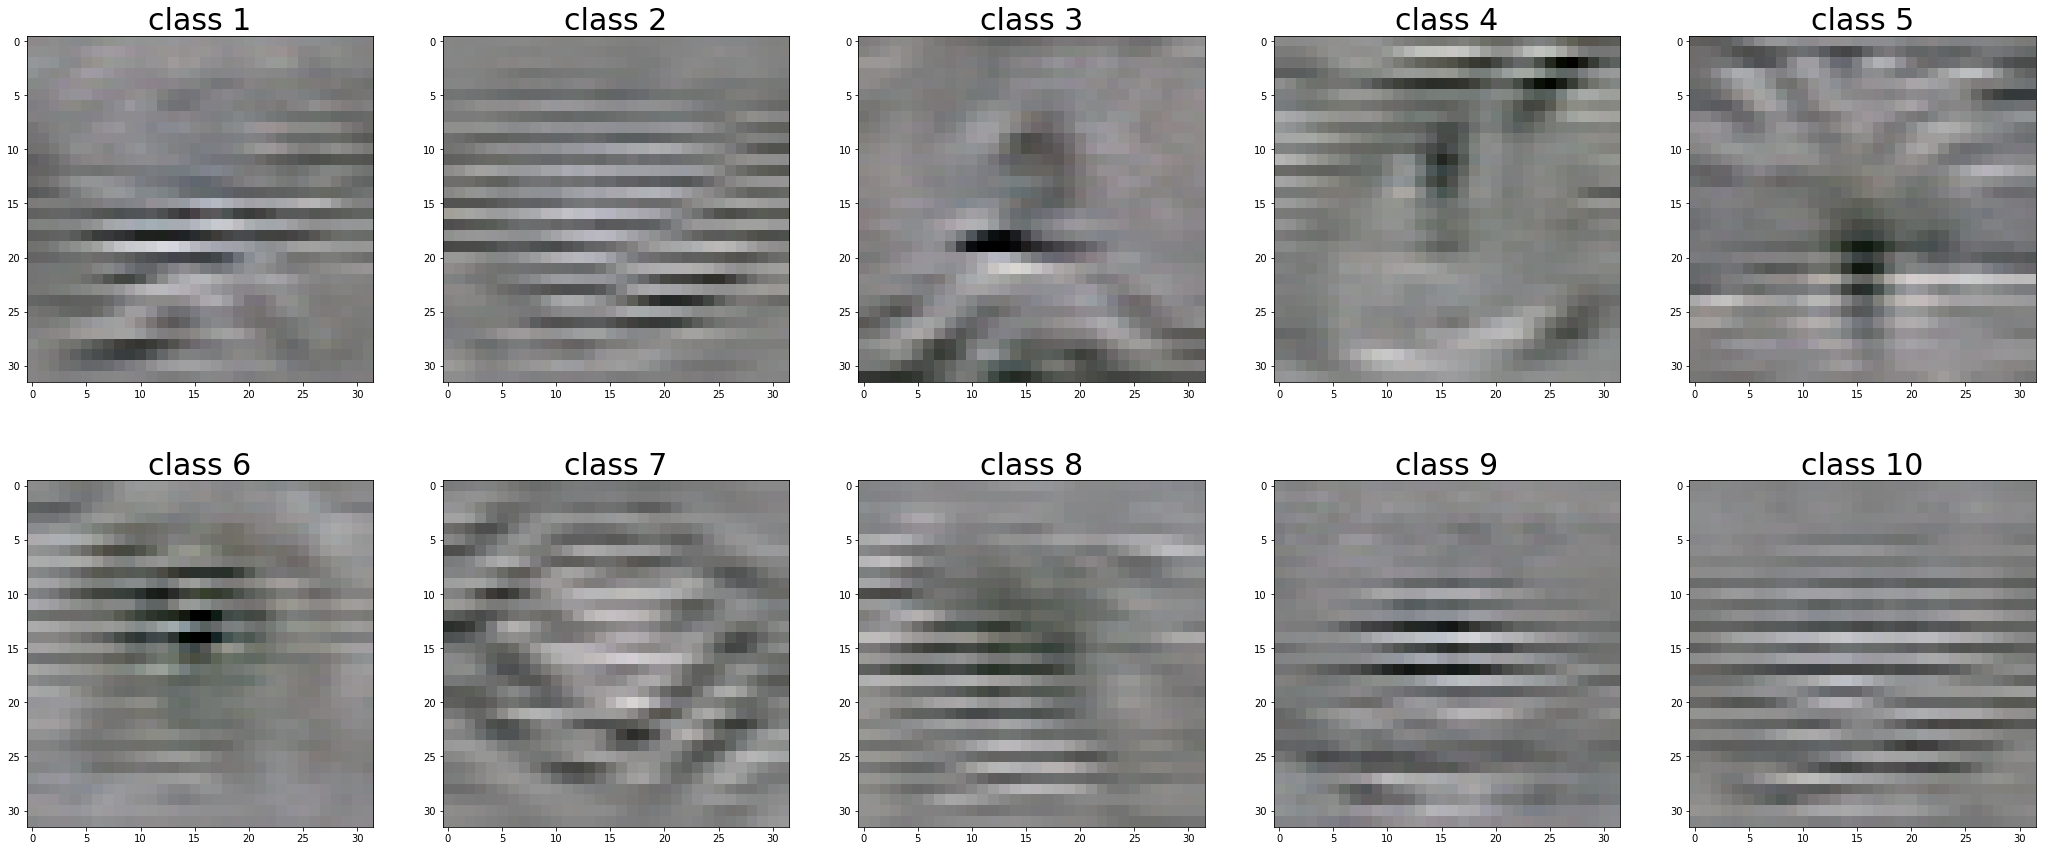

In [24]:
g_images = []
fig_act = plt.figure(figsize=(36,15))
for class_idx in range(10):
    img = init_img[np.newaxis, :]
    new_img = visualize_activation(keras_model, class_idx, img, n_iteration=100, verbose=False)
    new_img = deprocess_image(new_img)
    g_images.append(new_img) 
    plt.subplot(2,5,class_idx+1)
    plt.imshow(new_img[0,:])
    plt.title("class %d" %(int(class_idx)+1),fontsize=30)
plt.show()

In [26]:
for class_idx in range(10):
    scores = keras_model.predict(g_images[class_idx])
    print("score distribution when we set class as %d"% class_idx )
    print(scores) # input iamges that can activate the cnn model maximumly

score distribution when we set class as 0
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
score distribution when we set class as 1
[[3.4174303e-04 9.9965823e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
score distribution when we set class as 2
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
score distribution when we set class as 3
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
score distribution when we set class as 4
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
score distribution when we set class as 5
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
score distribution when we set class as 6
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
score distribution when we set class as 7
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
score distribution when we set class as 8
[[0.00115583 0.         0.         0.         0.         0.
  0.         0.         0.         0.99884415]]
score distribution when we set class as 9
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


From above we can find, compared with images without regularization,images after regularization have relatively higher confidence rate in their respective classes. In other words, images score very high for a single class even if they are unrecognizable by humans.